# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# Load pickled data
import pickle
import numpy as np
import cv2

training_file = "../traffic-signs-data/GTSRB_size32/train.p"
testing_file = "../traffic-signs-data/GTSRB_size32/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# Number of training examples
n_train = len(train['features'])
# Number of testing examples
n_test = len(test['features'])
# What's the shape of an image?
image_shape = train['features'][0].shape
# How many classes are in the dataset
n_classes = np.max(train['labels']) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


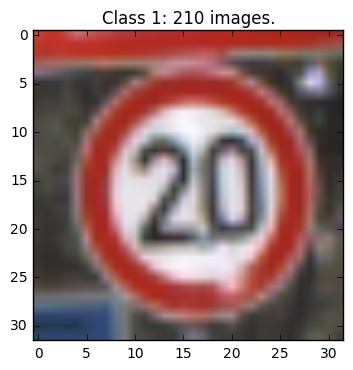

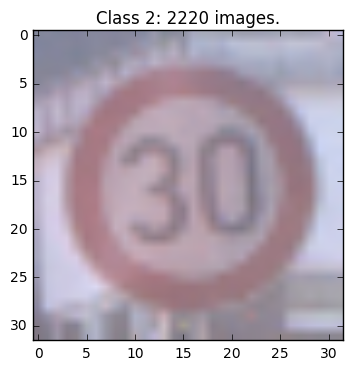

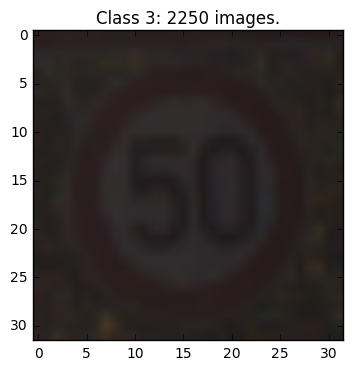

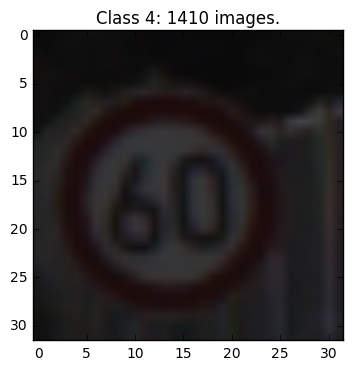

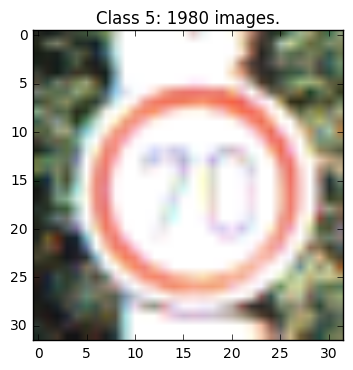

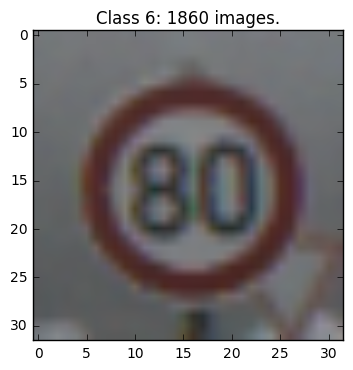

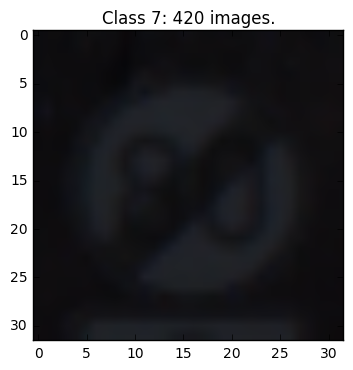

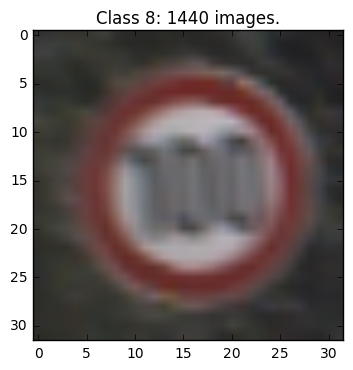

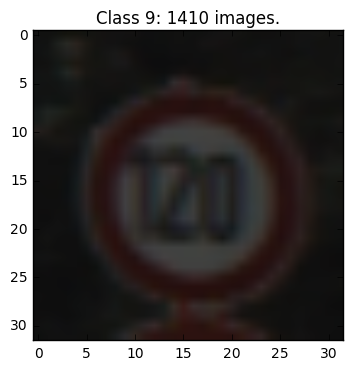

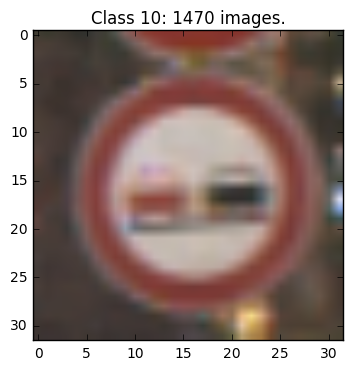

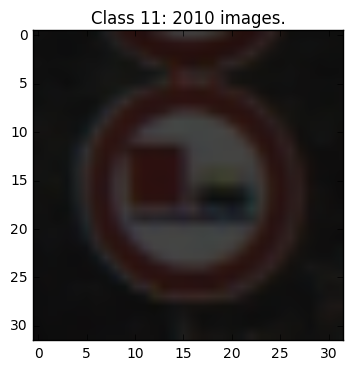

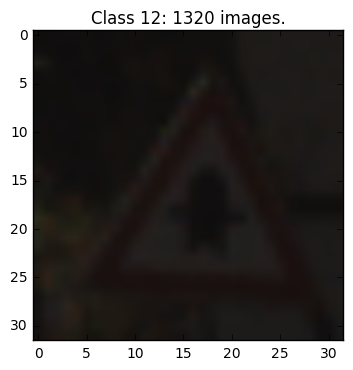

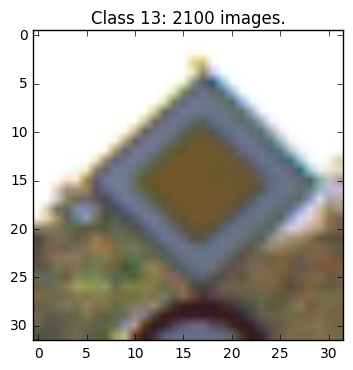

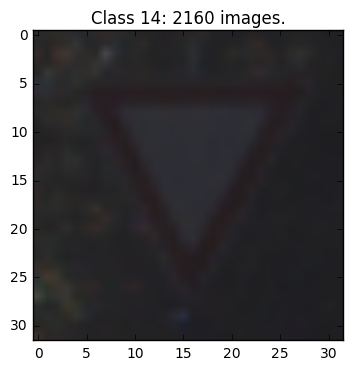

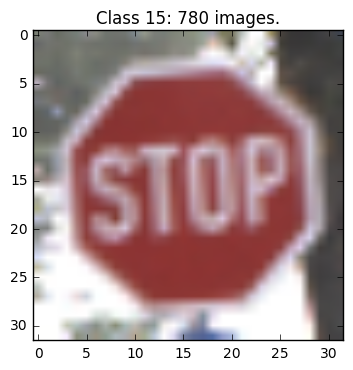

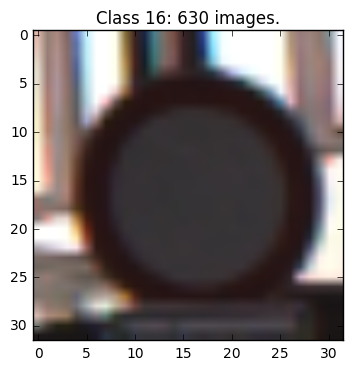

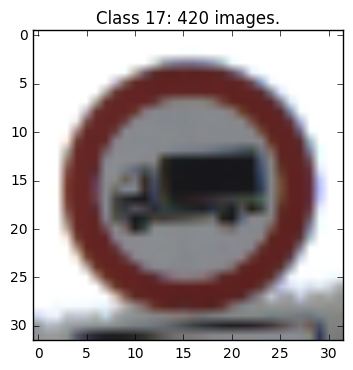

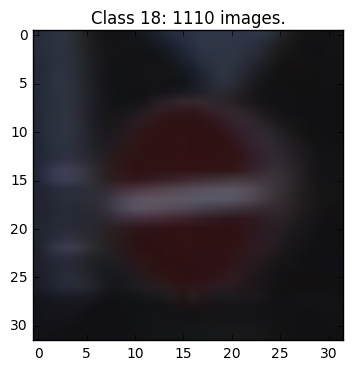

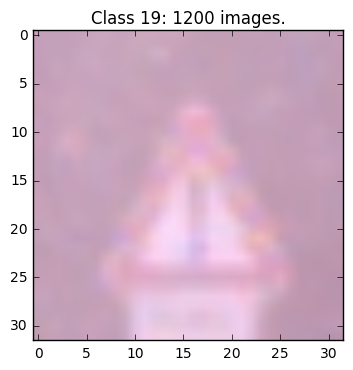

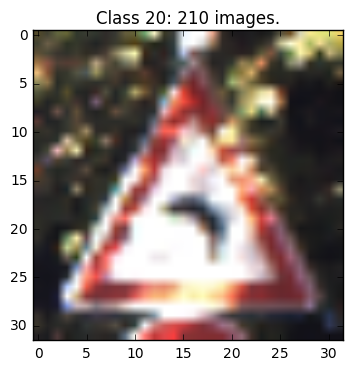

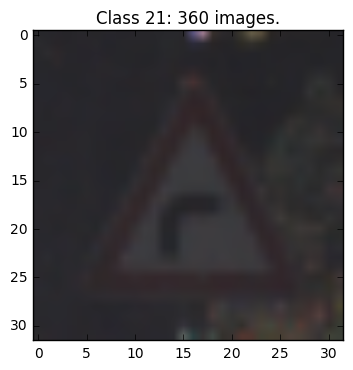

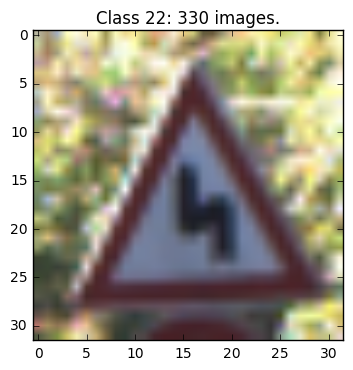

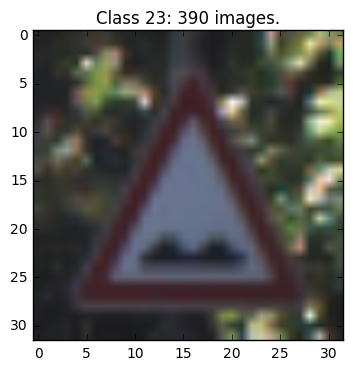

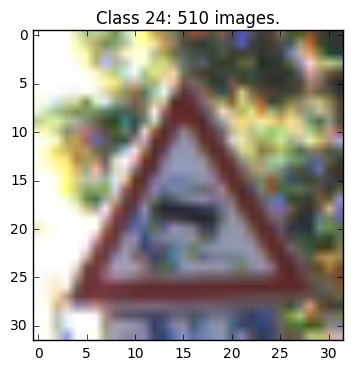

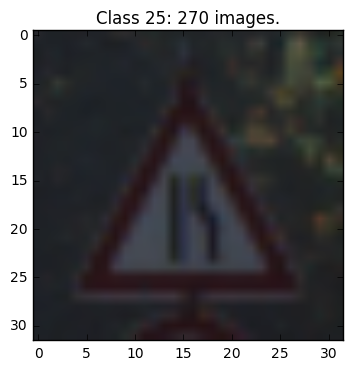

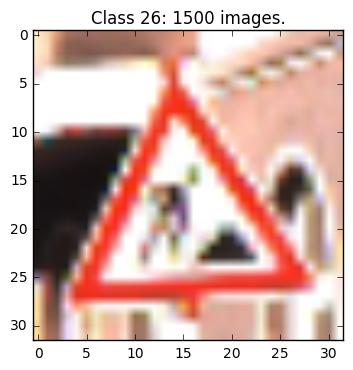

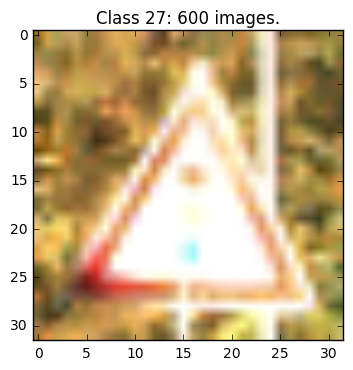

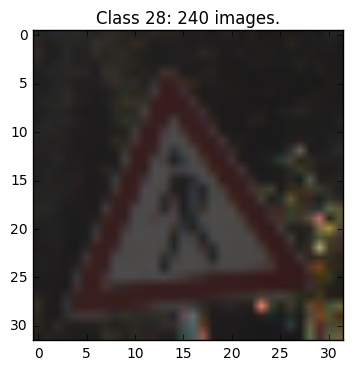

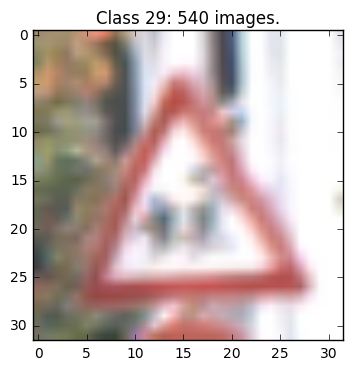

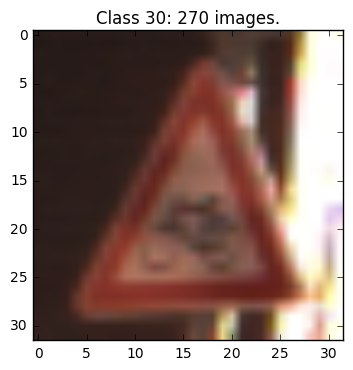

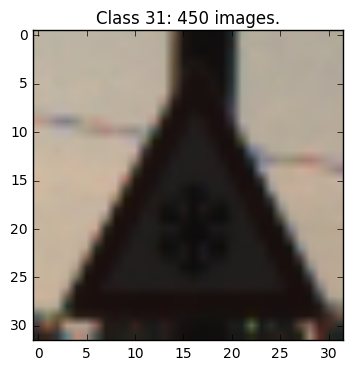

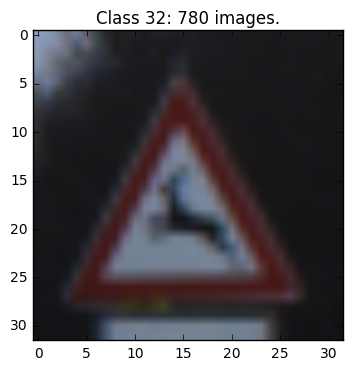

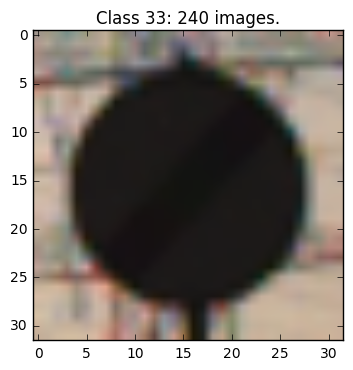

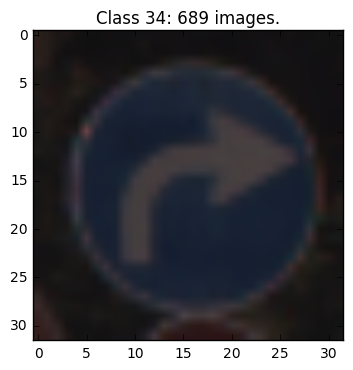

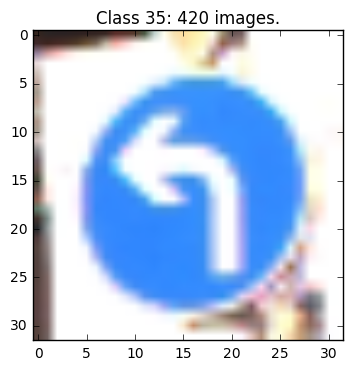

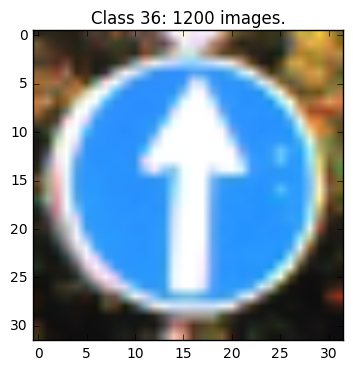

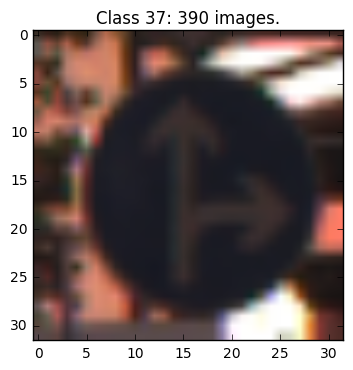

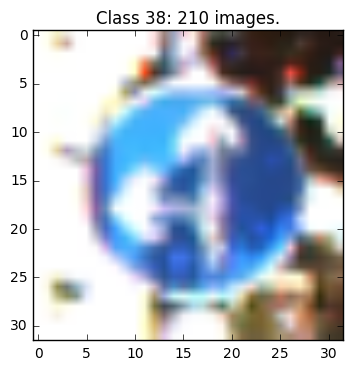

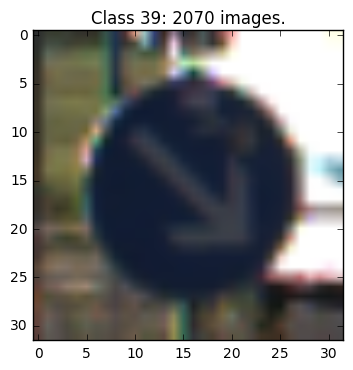

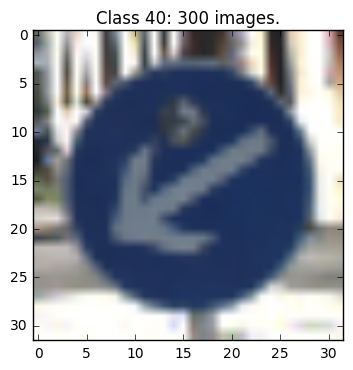

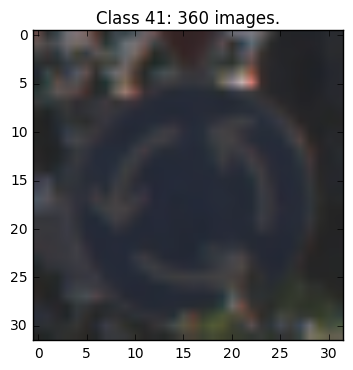

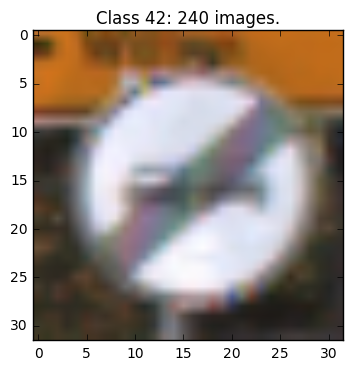

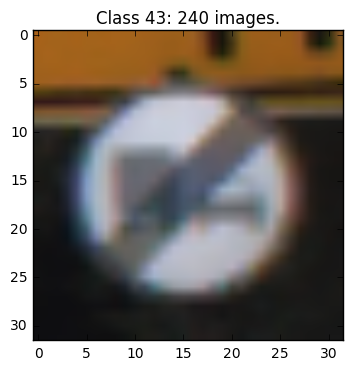

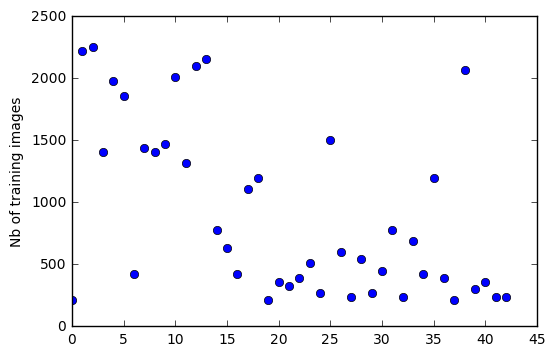

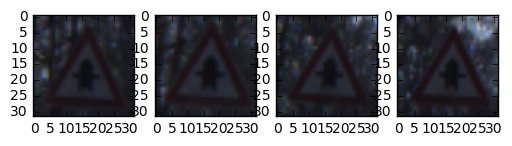

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt

# Show typical image for every class and the number of items in it.
nb_per_class = np.zeros((n_classes,), dtype=int)
for i in range(n_classes):
    nb_per_class[i] = np.sum(train['labels']==i)
    idxes = np.argwhere(train['labels']==i)
    plt.imshow(train['features'][idxes[20][0]])
    plt.title('Class %i: %i images.' % (i+1, nb_per_class[i]))
    plt.show()
    
# Graph of the number of items per class
plt.plot(nb_per_class, 'bo')
plt.ylabel('Nb of training images')
plt.show()

# Some blurry(!) images
nb_plots = 4
delta = 17900
for i in range(nb_plots):
    plt.subplot(1, nb_plots, i+1)
    plt.imshow(train['features'][delta+i])
plt.show()


# print(train['features'][0].shape)
# print(train['labels'].dtype)
# print(train['features'][0])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# General Pipeline | Answer 0

## TensorFlow-Slim
For this second problem, I decided to use the recent library [TensorFlow-Slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) built on top of TensorFlow. Similar to Keras, it provides a simpler interface to quickly define, train and test Neural Networks (and especially CNNs).

Besides having previous experience with the former, I decided over the latter for several reasons:
* TF-Slim is directly built on TensorFlow: one can use the simpler interface combined with more advanced features of TensorFlow. Allows very flexible setups, more than the abstract interface of Keras.
* The general pipeline is IMHO more robust than Keras: the data is pre-processed in parallel threads, filling in advances queues so that the GPU does not have to wait. Multiple GPUs work out of the box, with even the possibility of synchronising computations on multiple servers.

The single drawback I can see is that the community around Keras is larger, providing more contrib packages/layers and so on. But TensorFlow anyway also has a very strong community!

## Pipeline

For my general pipeline, I took inspiration from the implementation of common deep CNNs in TF-Slim (https://github.com/tensorflow/models/tree/master/slim). Basically, the pipeline is divided into three main components - directories:
* datasets: Files in this directory describe the structure of the dataset, how to convert to TFRecords, and some data generation if necessary.
* preprocessing: Define the preprocessing of train and test datasets (color variations and so on)
* nets: Definition of the CNNs architecture, using TF-Slim easy interface.

In addition, I kept the two main scripts 'train_image_classifier.py' and 'eval_image_classifier.py' for training and evaluating the CNNs.

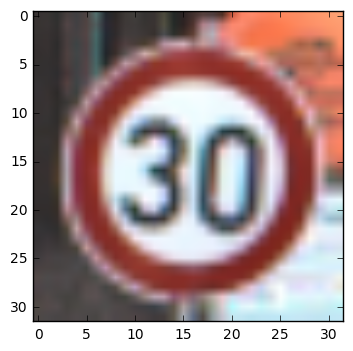

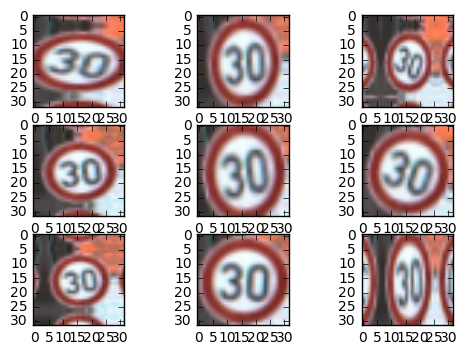

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def random_transform(img, max_angle, scale_range):
    """Apply some random transform (rotation + scaling) to an image.

    Sample uniformly the transformation parameters.
    Used for data augmentation when converting to TFRecords.
    """
    rows, cols, chs = img.shape

    # Rotation and scaling. Note: reverse axis on OpenCV
    angle = np.random.uniform(low=-max_angle, high=max_angle)
    rot_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1.)
    img = cv2.warpAffine(img, rot_matrix, (cols, rows),
                         flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_REFLECT_101)

    # Scaling matrix: keep image centered after scaled.
    scale_x = np.random.uniform(low=scale_range[0], high=scale_range[1])
    scale_y = np.random.uniform(low=scale_range[0], high=scale_range[1])
    scale_matrix = np.array([[scale_x, 0., (1. - scale_x) * cols / 2.], 
                             [0., scale_y, (1. - scale_y) * rows / 2.]], 
                            dtype=np.float32)
    img = cv2.warpAffine(img, scale_matrix, (cols, rows), 
                         flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_REFLECT_101)
    return img

idx = 2000
plt.imshow(train['features'][idx])
plt.show()

nb_plots = 3
for i in range(nb_plots**2):
    plt.subplot(nb_plots, nb_plots, i+1)
    plt.imshow(random_transform(train['features'][idx], 20., [0.6, 1.4]))
plt.show()

In [5]:
def preprocess_for_train(image,
                         output_height,
                         output_width,
                         padding=4):
    """Real-time preprocessing of images in the TF-Slim pipeline:
    - random cropping;
    - random brightness and contrast modifications.
    """
    tf.image_summary('image', tf.expand_dims(image, 0))

    # Transform the image to floats.
    image = tf.to_float(image)
    if padding > 0:
        image = tf.pad(image, [[padding, padding], [padding, padding], [0, 0]])
    # Randomly crop a [height, width] section of the image.
    distorted_image = tf.random_crop(image,
                                     [output_height, output_width, 3])

    # Randomly flip the image horizontally.
    # Not a good idea for traffic sign!!!
    # distorted_image = tf.image.random_flip_left_right(distorted_image)
    # Random contrast and brightness.
    distorted_image = tf.image.random_brightness(distorted_image,
                                                 max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image,
                                               lower=0.2, upper=1.8)

    tf.image_summary('distorted_image', tf.expand_dims(distorted_image, 0))
    # Subtract off the mean and divide by the variance of the pixels.
    return tf.image.per_image_whitening(distorted_image)

The two previous fonctions are part of my code:
* `random_transform` is implemented in the source file `tf_convert_gtsrb_32_transform.py` in charge of converting the dataset to TFRecords and generating additional synthetic data;
* `preprocess_for_train` is implemented in the source file `gtsrb_32_preprocessing.py` which generate additional distortions on-the-fly during training.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

I tested a few different techniques for preprocessing the data. To begin with, I add to my TF-slim preprocessing pipeline some simple random transforms:
* cropping, to enforce translation-invariant and partial mask on the image;
* random brightness and contrast, to obtain as well a more robust classification, independent of light conditions.
Both transforms are performed using standard Tensorflow image functions, and parameters are inspired by the same preprocessing techniques on Cifar10 and ImageNet datasets.

Finally, every training or testing image is whitened, i.e. on every color channel, the mean is substracted and the variance normalised to one.

After training some simple models with this initial configuration, I discovered that my network had a tendancy to over-fit (accurracy equal to 1 on training dataset, but not getting better than 0.96 on the testing one). Since adding more L2-regularisation would not completely overcome this problem, I decided to generate additional data using more complex geometric transforms:
* random rotations += 20 degrees;
* random scaling of X and Y axes, between 0.6 and 1.4.

Note that I used OpenCV to perform this task, as TensorFlow does not handle yet direct affine or rotation transforms on images. In addition to these transforms, I also balanced the number of images per class in order to avoid an over-representaion of some classes during training, leading to some bias of the network at the end.

I summarized this pre-processing steps in the following table:

| Pre-processing type |  Stage | Generate synthetic data |
|----------|:-------------:|:------:|
| Random transform: rotation + scaling     |  before training | Yes: 50 000 points per class |
| Random Crop + Ligthness +Contrast     |  during training | No: transform applied every time an image shows up  |

Hence, compared to the original dataset (39209 images), I generated around 2 000 000 images using random rotations and scaling. It may be an overkill, but it was a way to be sure that the new dataset was balanced, and at the same time, every image is the original dataset has been randomly modified around 25 times.


In [6]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

As previously presented, my pipeline follows the structure of TF-Slim. Hence, the data is converting to TFRecords files which can be handled directly by TensorFlow. Complex geometrical transforms such as rotation and scaling are added while generating the TFRecords files. Additional transforms on contrast and lightness are automatically generated while training the network.

In [7]:
import tensorflow as tf
slim = tf.contrib.slim

### Define your architecture here.
def cifarnet(images, num_classes=43, is_training=False,
             dropout_keep_prob=0.5,
             prediction_fn=slim.softmax,
             scope='CifarNet'):
    """Creates a variant of the CifarNet model.
    """
    end_points = {}

    with tf.variable_scope(scope, 'CifarNet', [images, num_classes]):
        net = slim.conv2d(images, 64, [5, 5], scope='conv1')
        end_points['conv1'] = net
        net = slim.max_pool2d(net, [2, 2], 2, scope='pool1')
        end_points['pool1'] = net
        net = tf.nn.lrn(net, 4, bias=1.0, alpha=0.001/9.0, beta=0.75, name='norm1')
        net = slim.conv2d(net, 64, [5, 5], scope='conv2')
        end_points['conv2'] = net
        net = tf.nn.lrn(net, 4, bias=1.0, alpha=0.001/9.0, beta=0.75, name='norm2')
        net = slim.max_pool2d(net, [2, 2], 2, scope='pool2')
        end_points['pool2'] = net
        net = slim.flatten(net)
        end_points['Flatten'] = net
        net = slim.fully_connected(net, 384, scope='fc3')
        end_points['fc3'] = net
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                           scope='dropout3')
        net = slim.fully_connected(net, 192, scope='fc4')
        end_points['fc4'] = net
        logits = slim.fully_connected(net, num_classes,
                                      biases_initializer=tf.zeros_initializer,
                                      weights_initializer=trunc_normal(1/192.0),
                                      weights_regularizer=None,
                                      activation_fn=None,
                                      scope='logits')

        end_points['Logits'] = logits
        end_points['Predictions'] = prediction_fn(logits, scope='Predictions')
    return logits, end_points

In [8]:
def idsianet(images, num_classes=43, is_training=False,
             dropout_keep_prob=0.5,
             prediction_fn=slim.softmax,
             scope='IdsiaNet'):
    """Creates a variant of the IDSIA model.
    """
    end_points = {}

    with tf.variable_scope(scope, 'IdsiaNet', [images, num_classes]):
        net = slim.conv2d(images, 100, [7, 7], scope='conv1')
        end_points['conv1'] = net
        net = slim.max_pool2d(net, [2, 2], 2, scope='pool1')
        end_points['pool1'] = net
        net = slim.conv2d(net, 150, [4, 4], scope='conv2')
        end_points['conv2'] = net
        net = slim.max_pool2d(net, [2, 2], 2, scope='pool2')
        end_points['pool2'] = net
        net = slim.conv2d(net, 250, [4, 4], scope='conv3')
        end_points['conv3'] = net
        net = slim.max_pool2d(net, [2, 2], 2, scope='pool3')
        end_points['pool3'] = net
        net = slim.flatten(net)
        end_points['Flatten'] = net
        net = slim.fully_connected(net, 300, scope='fc1')
        end_points['fc1'] = net
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                           scope='dropout1')
        logits = slim.fully_connected(net, num_classes,
                                      biases_initializer=tf.zeros_initializer,
                                      weights_initializer=trunc_normal(1/300.0),
                                      weights_regularizer=None,
                                      activation_fn=None,
                                      scope='logits')
        end_points['Logits'] = logits
        end_points['Predictions'] = prediction_fn(logits, scope='Predictions')
    return logits, end_points

In [9]:
def atrousnet_valid(images, num_classes=43, is_training=False,
                    dropout_keep_prob=0.5,
                    prediction_fn=slim.softmax,
                    scope='AtrousNet'):
    """Creates a model using Dilated-Atrous convolutions.
    """
    end_points = {}

    with tf.variable_scope(scope, 'AtrousNet', [images, num_classes]):

        net = slim.conv2d(images, 64, [3, 3], padding='VALID',
                          weights_regularizer=None, scope='conv1')
        end_points['conv1'] = net
        net = slim.conv2d(net, 128, [3, 3], rate=2, padding='VALID',
                          weights_regularizer=None, scope='conv2')
        end_points['conv2'] = net
        net = slim.max_pool2d(net, [3, 3], 1, scope='pool2', padding='SAME')
        net = slim.conv2d(net, 192, [3, 3], rate=3, padding='VALID',
                          weights_regularizer=None, scope='conv3')
        end_points['conv3'] = net
        # net = slim.max_pool2d(net, [3, 3], 1, scope='pool3', padding='SAME')
        net = slim.conv2d(net, 256, [3, 3], rate=4, padding='VALID',
                          weights_regularizer=None, scope='conv4')
        end_points['conv4'] = net
        # net = slim.max_pool2d(net, [3, 3], 1, scope='pool4', padding='SAME')

        net = slim.conv2d(net, 512, [1, 1], scope='conv5')
        end_points['conv5'] = net
        net = slim.dropout(net, dropout_keep_prob,
                           is_training=is_training,
                           scope='dropout1')
        net = slim.conv2d(net, num_classes+1, [1, 1],
                          biases_initializer=tf.zeros_initializer,
                          weights_initializer=trunc_normal(1 / 512.0),
                          weights_regularizer=None,
                          activation_fn=None,
                          scope='conv6')
        end_points['conv6'] = net
        end_points['PredictionsFull'] = tf.nn.softmax(net)

        # Global average pooling.
        logits = tf.reduce_mean(net, [1, 2], name='pool7')
        end_points['Logits'] = logits
        end_points['Predictions'] = prediction_fn(logits, scope='Predictions')
    return logits, end_points

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In this project, I tried several Convolutional Neural Networks architectures. It was a way for me to get more expertise in training CNNs, and get more intuition of the advantages and inconvenients of different architectures of neural networks.

#### CifarNet
I started with a very standard solution, the historical LeNet CNN! It was a natural choice as it is historically one of the first well-performing CNN on a classification task (i.e. numbers on the dataset MNIST). More specifically, I chose to test a slightly more advanced version, CifarNet, with Local Response Normalisation and an additional Fully Connected layers. The latter design is given in the advanced TensorFlow [tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/deep_cnn/index.html) and used for a classification task on the Cifar10. Since we are interested as well in a classification task, and Cifar10 and GTSRB are similar datasets in terms of size and number of classes, it seemed natural to investigate this model. It has the following architecture:

| Layer type |  Size | Stride | Padding | Output Depth | Output Height x Width |
|----------|:-------------:|:------:|:------:|:------:|:------:|
| Convolution     |  5x5 | 1 | SAME | 64 | 32x32 |
| Max Pool        |  2x2 | 2 | SAME | 64 | 16x16 |
| LRN     |  - | - | - | 64 |16x16 |
| Convolution     |  5x5 | 1 | SAME | 64 |16x16 |
| Max Pool        |  2x2 | 2 | SAME | 64 |8x8 |
| LRN     |  - | - | - | 64 | 8x8 |
| Fully Connected | -    | - | - | 384 | - |
| Dropout p=0.5     | -    | - | - | 384 | - |
| Fully Connected | -    | - | - | 192 | - |
| Fully Connected | -    | - | - | 43 | - |
| Softmax | -    | - | - | 43 | - |

#### IdsiaNet
Even though the previous architecture offers good performances, I looked at networks optimised for the traffic sign dataset. Namely, taking inspiration from two main papers on the topic [[1]](https://www.google.co.uk/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjMp6S08JbQAhXDJ8AKHXBwDZgQFggeMAA&url=http%3A%2F%2Fyann.lecun.com%2Fexdb%2Fpublis%2Fpdf%2Fsermanet-ijcnn-11.pdf&usg=AFQjCNEtvdz_vnI9tg1wF96UcjxVYwxdHw&sig2=lvgIdNJuRJZ_MZ-6tFUpHQ&bvm=bv.137904068,d.d24), [[2]](https://www.google.co.uk/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjiooqc8JbQAhXjD8AKHaljDN0QFggeMAA&url=http%3A%2F%2Fpeople.idsia.ch%2F~juergen%2Fnn2012traffic.pdf&usg=AFQjCNGHd_VYgMjQ4MHdhFvPIhB_ukdQ2g&sig2=hhnazlK3ROuhEGN5B1txTQ&bvm=bv.137904068,d.d24) and [[3]](http://torch.ch/blog/2015/09/07/spatial_transformers.html). Since [2] was the leading CNN at the time on the GTSRB dataset, I tried directly the architecture described in this paper:

| Layer type |  Size | Stride | Padding | Output Depth | Output Height x Width |
|----------|:-------------:|:------:|:------:|:------:|:------:|
| Convolution     |  7x7 | 1 | SAME | 100 | 32x32 |
| Max Pool        |  2x2 | 2 | SAME | 100 | 16x16 |
| Convolution     |  4x4 | 1 | SAME | 150 | 16x16 |
| Max Pool        |  2x2 | 2 | SAME | 150 | 8x8 |
| Convolution     |  4x4 | 1 | SAME | 250 | 8x8 |
| Max Pool        |  2x2 | 2 | SAME | 250 | 4x4 |
| Fully Connected | -    | - | - | 300 | - |
| Dropout p=0.5     | -    | - | - | 300 | - |
| Fully Connected | -    | - | - | 43 | - |
| Softmax | -    | - | - | 43 | - |
Note that this network does not make use of Local Response Normalization layers. Even though used for sometimes in the literature, it seems that this techniques has been lately dropped in common practices, and replaced by Dropout, L2-Normalisation and Batch Normalisation. I do not use the latter as well, as it is mainly beneficial while training deep networks (> 15 layers), which is clearly not the case of this project!

#### AtrousNet

Finally, I tried a third type of architecture, inspired by more recent articles on convolutional neural networks and segmentation. It is based on the work [[1]](https://arxiv.org/pdf/1511.07122v3.pdf) which makes use of dilated convolutions on segmentation tasks. An important idea of this architecture is too avoid pooling layers with stride > 1 and remove the fully connected layers, replacing them with 1x1 convolutions, in order to keep a full resolution output which can be directly used for segmentation (and thus not only classification). Besides the work [1], it seems that the use of dilated convolutions is gaining momentum in the recent deep neural network literature, with many different applications in segmentation [1], [[2]](https://arxiv.org/abs/1606.02147), audio generative models [[3]](https://arxiv.org/pdf/1609.03499.pdf) or machine translation [[4]](https://arxiv.org/pdf/1610.10099v1.pdf).

An important motivation of the architecture was to test whether a neural network could also directly provide segmentation - localisation information, by generating a softmax probability map on every pixel, and still perform as well as previous architectures. Compared to the original work [1], I investigated a simpler architecture (4 3x3 convolution layers instead of 7) with a linear dilation rate from one layer to another (the exponential rate investigated [1] grows too fast for small images). Finally, compared to the two previous networks, I used a VALID padding in the convolution layers, as the later seemed in experiments more stable than a SAME padding. The downside of this choice is to narrow down the output height and width, but in practice, it does not affect the quality of the classification, but improve the segmentation mask.

| Layer type |  Size | Stride | Padding  | Dilation | Output Depth | Output Height x Width |
|----------|:-------------:|:------:|:------:|:------:|:------:|:------:|
| Convolution     |  3x3 | 1 | VALID  | 1 | 64 | 30x30 |
| Convolution     |  3x3 | 1 | VALID | 2 | 128 | 26x26 |
| Max Pool        |  3x3 | 1 | SAME | - | 128 | 26x26 |
| Convolution     |  3x3 | 1 | VALID | 3 | 192 | 20x20 |
| Convolution     |  3x3 | 1 | VALID | 4 | 256 | 12x12 |
| Convolution     |  1x1 | 1 | SAME | 1 | 512 | 12x12 |
| Dropout p=0.5     | -    | - | - | - | 512 | 12x12 |
| Convolution     |  1x1 | 1 | - | 1 | 43 | 12x12 |
| Softmax Map    |  - | - | - | 1 | 43 | 12x12 |
| Reduce Mean    |  - | - | - | 1 | 43 | 1x1 |

Note that we use the last two layers for classification and localization in the image: the first one provides a probability map on the image of where the sign would be localized, whereas the second provides a global score on the probability of every sign to exist on the image.

I decided to choose this model as my main model in this project.


In [10]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Hyper-parameters choice

I first ran short training, stopping after 5k iterations (around 1/2 epoch on the augmented dataset). The main goal was to compare a few hyper-parameters and check with which ones the optimisation seemed to perform the best:
* learning rate: 0.01, 0.05, 0.1, 0.5
* batch size: 32, 64, 128, 256;
* rmsprop epsilon parameter: 0.00001, 0.001, 1.0.

I kept the parameters which provided the best speed at early stage optimisation, without an oscillating or exploding factor. At the end, I decided to go for a learning rate of 0.1 (higher would great loss explosion), a batch size of 128 (256 did not seem to bring more, 64 and 32 were more noisy on the gradient descent) and a rmsprop epsilon of 1.0 (I did not see much differences on this parameter). 

### Full optimisation

I did not use a cross-validation dataset during the optimisation. It seemed to me that it is a quite common nowadays in the literature on CNNs, as it seemed more important nowadays to check the correct training of a model (not stuck in saddle points, no explosions, layers activation) than to check the classification result on the cross-validation dataset. Hence, I just used the augmented training set, and the test set to obtain the final performance of the model.

I decided to run the full optimisation for around 15 epochs (around 150k iterations) on the augmented dataset. The performance on the test dataset was already close to optimal after 2 epochs, but running for longer times allow to regularised the parameters (I used L2 regularisation with a weight of 0.00005), and thus obtain a more robust final model. The learning rate was set initially at 0.1, with an exponential decrease of 0.9 every epoch (my bad for the initial values, I kept the first parameters I used on the non-augmented dataset).


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

There is a quite large literature on traffic sign classification and neural networks. Better take inspiration from it! Hence, for inspiration, I looked mostly at important articles on this problem, and more broadly, on the topic of classification and segmentation using Convolutional Neural Networks. 

Concerning the training, I used similarly standard learning rate and optimiser to obtain proper training. Comparing results on training and testing datasets, I come with the idea of augmenting the initial dataset, adding rotation and scaling transforms. Similarly, first trying with small transform parameters, I increased gradually the scale of latter to avoid over-fitting.

During this project, and more particularly, while training these different architectures, I ran into a few unexpected problems:
* Period oscillations of the loss function during training. It happened to be related to some inconsistent shuffling of the training data: basically, TensorFlow only shuffles data in the pipeline (~10x batch size), but not on the full data set. Hence, if the pipeline is too small, the shuffle only concerns data from the same class! As a simple fix of this problem, I pre-shuffled data before writing down the TFRecords files.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
# Load CSV signs description...
import csv

with open('signnames.csv', 'r') as f:
    creader = csv.reader(f)
    csv_list = list(creader)
    class_names = [a[1] for a in csv_list[1:]]
    class_names.append('NOTHING! NOTHING! NOTHING!')
    

## Accuracy on test dataset

Let us start by computing the accuracy of the previous network architectures on the test dataset:

| Architecture |  Test dataset accuracy | Top-5 accuracy |
|----------|:-------------:|:-------------:|
| CifarNet     |  96.3%  | 
| IdsiaNet     |  98.06%  | 
| AtrousNet     |  98.15%  | 99.85% |


Evaluating the classifier can be done easily using the following command (with the correct dataset directory provided):
```bash
DATASET_DIR=../traffic-signs-data/GTSRB_size32
CHECKPOINT_FILE=checkpoints/atrousnet_valid.ckpt
python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path=${CHECKPOINT_FILE} \
    --dataset_dir=${DATASET_DIR} \
    --dataset_name=gtsrb_32 \
    --dataset_split_name=test \
    --model_name=atrousnet_valid
```


In [12]:
import tensorflow as tf
slim = tf.contrib.slim

from nets import idsianet
from nets import atrousnet

from preprocessing import gtsrb_32_preprocessing

ckpt_file_idsianet = './checkpoints/idsianet.ckpt'
ckpt_file_atrousnet = './checkpoints/atrousnet_valid.ckpt'
ckpt_file_atrousnet2 = './checkpoints/atrousnet_same.ckpt'

img_shape = (idsianet.idsianet.default_image_size, idsianet.idsianet.default_image_size, 3)
num_classes = 43

def idsianet_model(image, shape):
    """Return a preprocessing + model with image as input.
    """
    img_size = idsianet.idsianet.default_image_size
    image = gtsrb_32_preprocessing.preprocess_for_eval(image, shape[0], shape[1])
    image = tf.reshape(image, shape=(1, *shape))
    
    with slim.arg_scope(idsianet.idsianet_arg_scope()):
        logits, end_points = idsianet.idsianet(image)
    return logits, end_points

def atrousnet_model(image, shape):
    """Return a preprocessing + model with image as input.
    """
    img_size = atrousnet.atrousnet_valid.default_image_size
    image = gtsrb_32_preprocessing.preprocess_for_eval(image, shape[0], shape[1])
    image = tf.reshape(image, shape=(1, *shape))
    
    with slim.arg_scope(atrousnet.atrousnet_valid_arg_scope()):
        logits, end_points = atrousnet.atrousnet_valid(image)
    return logits, end_points

def atrousnet_model_same(image, shape):
    """Return a preprocessing + model with image as input
    """
    img_size = atrousnet.atrousnet_same.default_image_size
    image = gtsrb_32_preprocessing.preprocess_for_eval(image, shape[0], shape[1])
    image = tf.reshape(image, shape=(1, *shape))
    
    with slim.arg_scope(atrousnet.atrousnet_same_arg_scope()):
        logits, end_points = atrousnet.atrousnet_same(image)
    return logits, end_points

def eval_model_on_image(image, model, ckpt_file):
    """Evaluation of the model on one image.
    Absolutely awfully optimised: reload everything at each call. But makes the job!
    
    return: class predicted + probabilities of each class.
    """
    with tf.Graph().as_default():
        # Image placeholder and model
        # image = image.astype(np.float32)
        img_shape = image.shape
        img_input = tf.placeholder(shape=img_shape, dtype=tf.uint8)
        logits, end_points = model(img_input, img_shape)

        with tf.Session() as session:
            # Restore checkpoint
            saver = tf.train.Saver()
            saver.restore(session, ckpt_file)
            # Run model.
            output = session.run(end_points, feed_dict={img_input: image})
            
    probabilities = output['Predictions'][0]
    return np.argmax(probabilities), probabilities, output

def eval_model_on_dataset(data, model, ckpt_file):
    """Evaluation of the model on a dataset. 
    Not so well-optimised as well! Could run it on batches to make it faster,
    but over-optimisation is the root of evil!
    
    return: class predicted + probabilities of each class.
    """
    with tf.Graph().as_default():
        # Image placeholder and model
        img_shape = data[0].shape
        img_input = tf.placeholder(shape=img_shape, dtype=tf.uint8)
        logits, end_points = model(img_input, img_shape)
        
        # Probabilities and predictions outputs.
        predictions = np.zeros(shape=(data.shape[0],), dtype=np.int)
        probabilities = np.zeros(shape=(data.shape[0], num_classes), dtype=np.float32)

        with tf.Session() as session:
            # Restore model checkpoint. 
            saver = tf.train.Saver()
            saver.restore(session, ckpt_file)
            for i in range(data.shape[0]):
                # Run model on every image of the dataset.
                image = data[i]
                output = session.run(end_points, feed_dict={img_input: image})
                
                probabilities[i] = output['Predictions'][0][:num_classes]
                predictions[i] = np.argmax(probabilities[i])
            
    return predictions, probabilities

In [48]:
# Run the AtrousNet model on the test dataset...
# Note: can take a bit of time to run! Around 5 minutes on average laptop.
test_predictions, test_probabilities = eval_model_on_dataset(X_test, atrousnet_model, ckpt_file_atrousnet)

In [76]:
# Accuracy of the model on every class on the test dataset.
print('Accuracy on the test dataset (%i images)...' % len(y_test))
for i in range(num_classes):
    mask = y_test==i
    accuracy = float(np.sum(y_test[mask]==test_predictions[mask])) / float(np.sum(mask))
    
    print('Class %i (%i | %i images) --- Accuracy: %.3f --- %s' % (i+1, 
                                                              np.sum(mask),
                                                              np.sum(y_train==i),
                                                              accuracy, 
                                                              class_names[i]))

Accuracy on the test dataset (12630 images)...
Class 1 (60 | 210 images) --- Accuracy: 1.000 --- Speed limit (20km/h)
Class 2 (720 | 2220 images) --- Accuracy: 1.000 --- Speed limit (30km/h)
Class 3 (750 | 2250 images) --- Accuracy: 0.997 --- Speed limit (50km/h)
Class 4 (450 | 1410 images) --- Accuracy: 0.982 --- Speed limit (60km/h)
Class 5 (660 | 1980 images) --- Accuracy: 0.991 --- Speed limit (70km/h)
Class 6 (630 | 1860 images) --- Accuracy: 0.990 --- Speed limit (80km/h)
Class 7 (150 | 420 images) --- Accuracy: 0.880 --- End of speed limit (80km/h)
Class 8 (450 | 1440 images) --- Accuracy: 0.998 --- Speed limit (100km/h)
Class 9 (450 | 1410 images) --- Accuracy: 0.998 --- Speed limit (120km/h)
Class 10 (480 | 1470 images) --- Accuracy: 1.000 --- No passing
Class 11 (660 | 2010 images) --- Accuracy: 0.998 --- No passing for vechiles over 3.5 metric tons
Class 12 (420 | 1320 images) --- Accuracy: 0.921 --- Right-of-way at the next intersection
Class 13 (690 | 2100 images) --- Accu

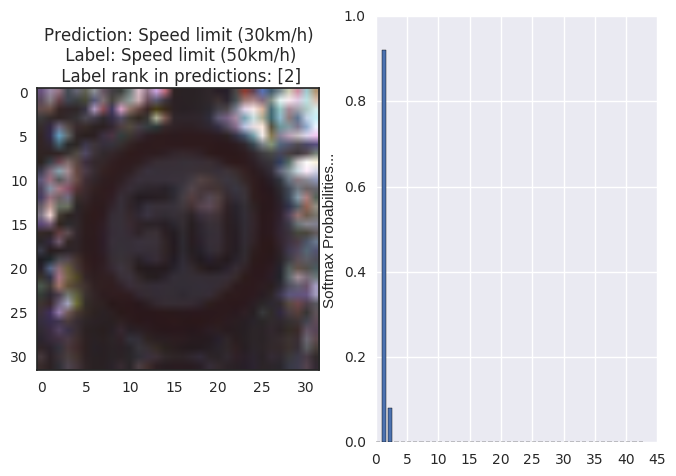

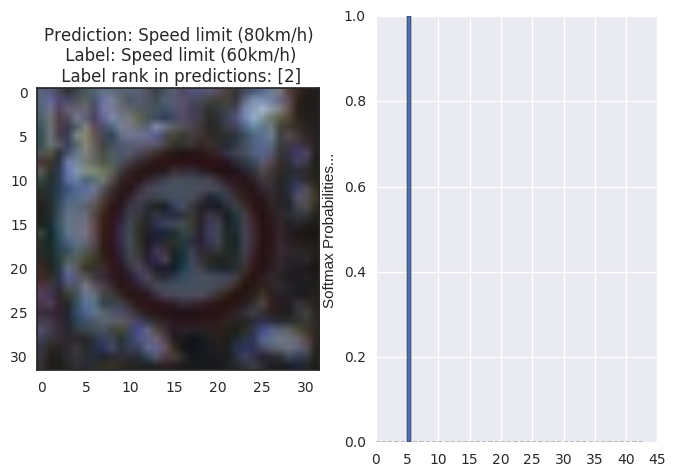

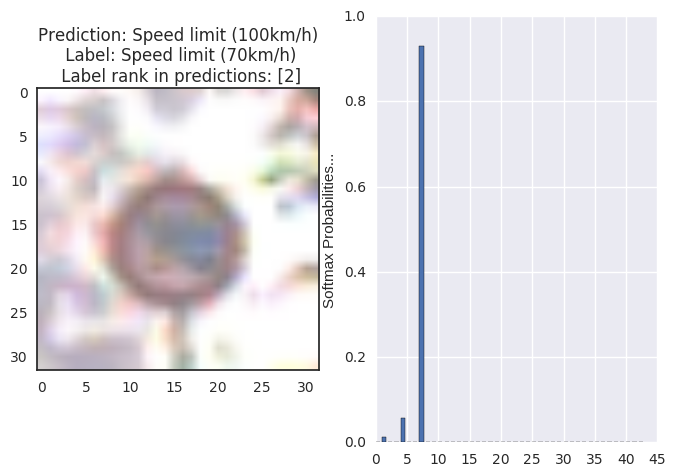

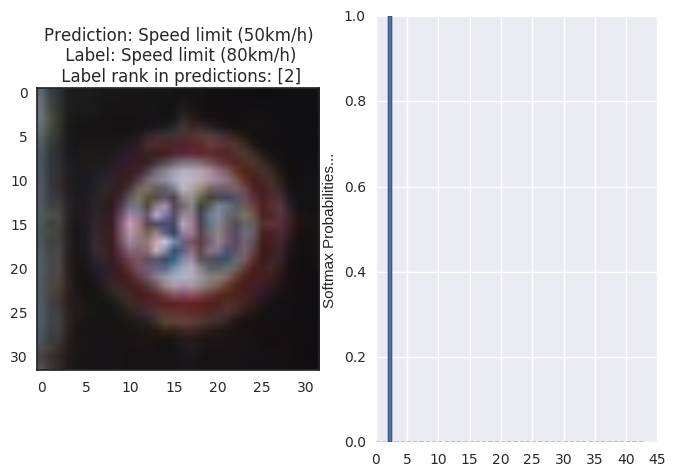

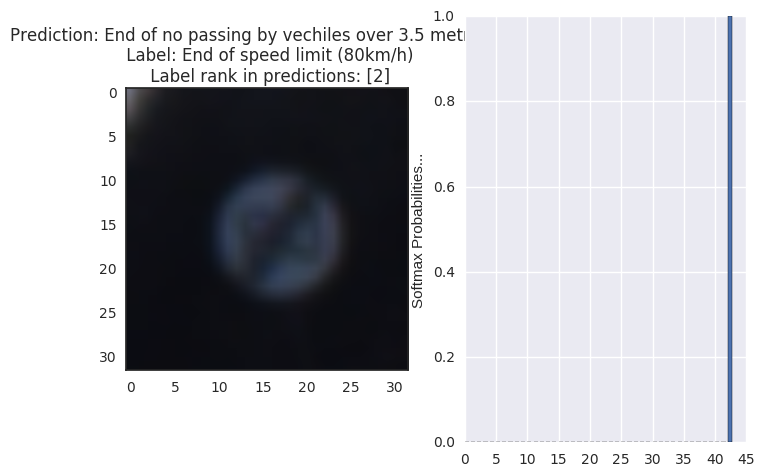

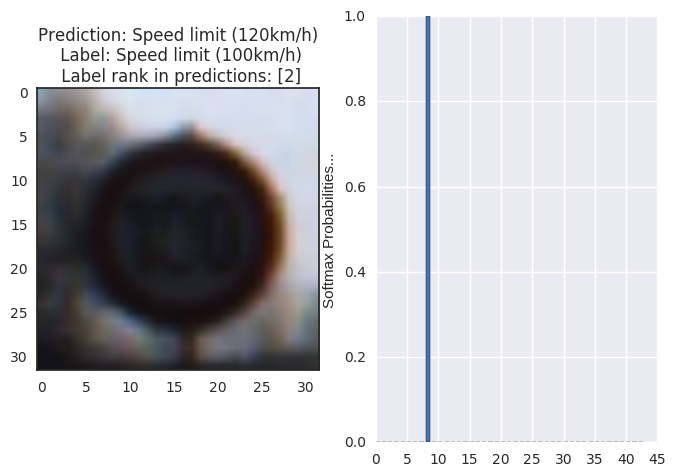

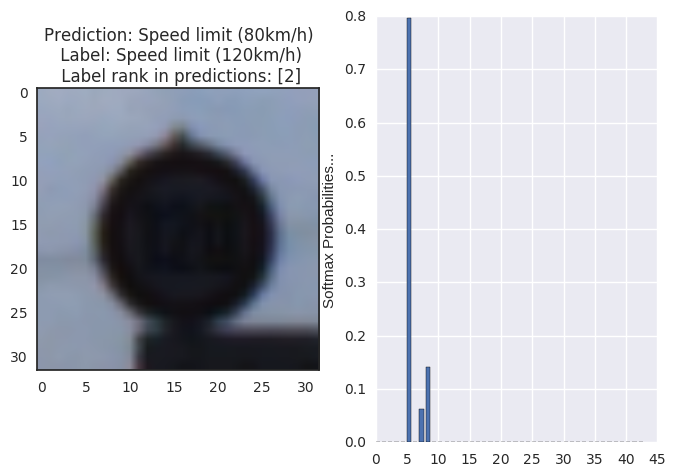

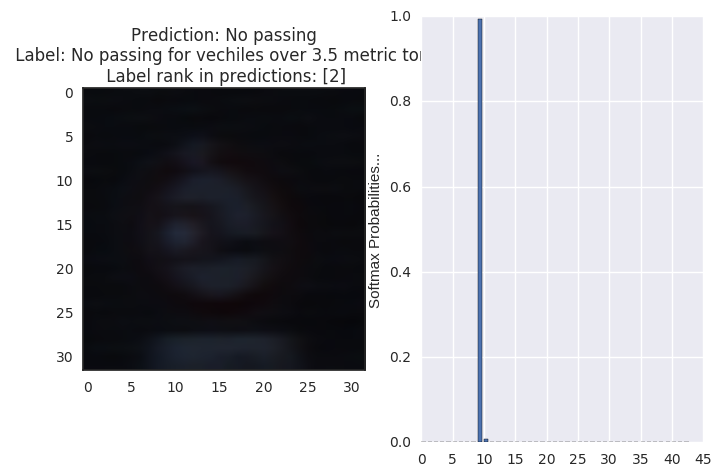

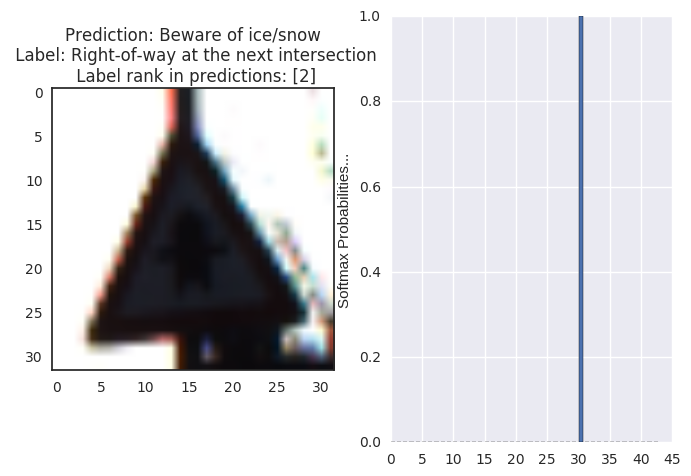

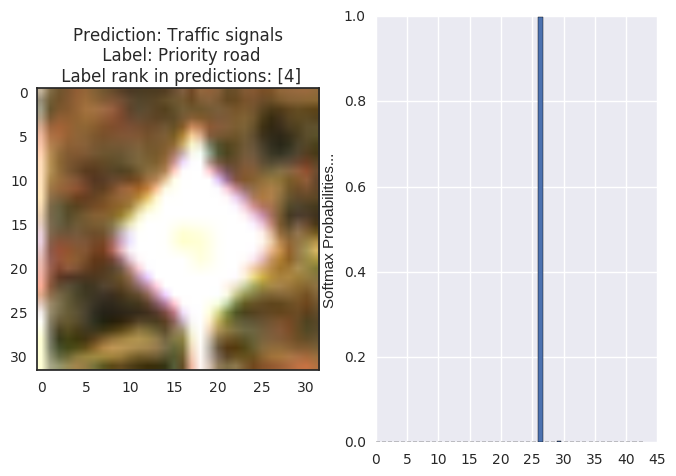

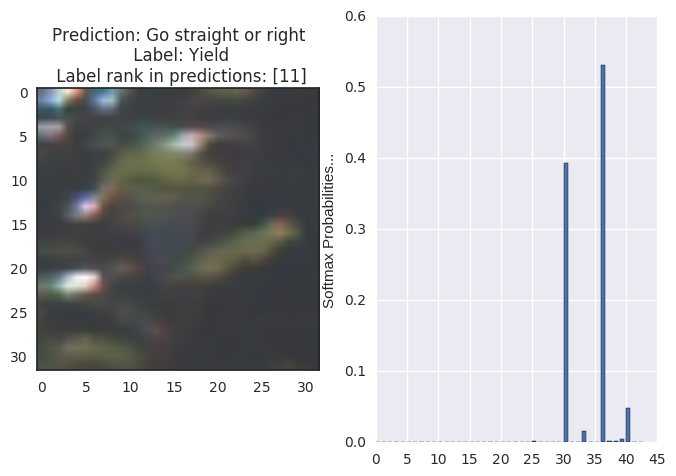

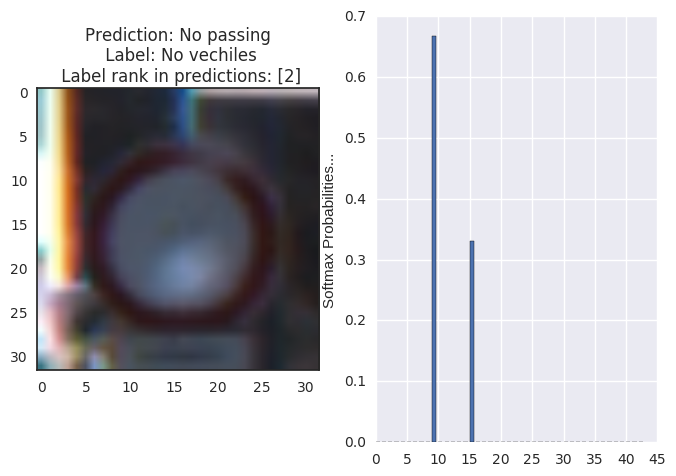

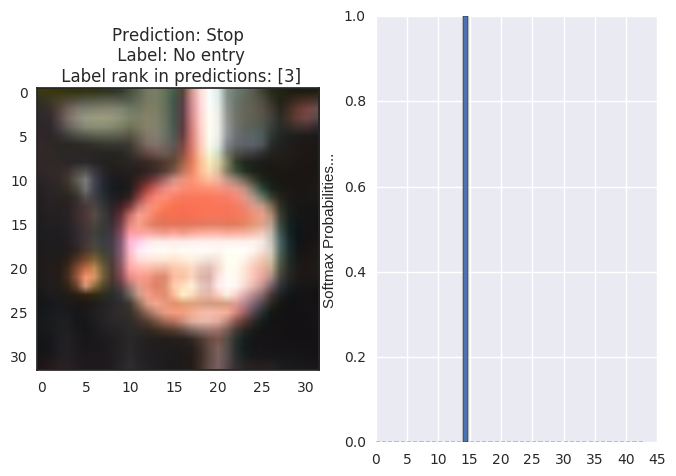

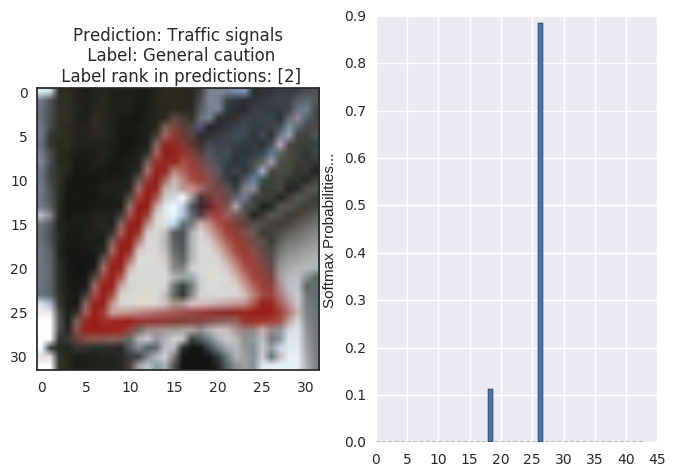

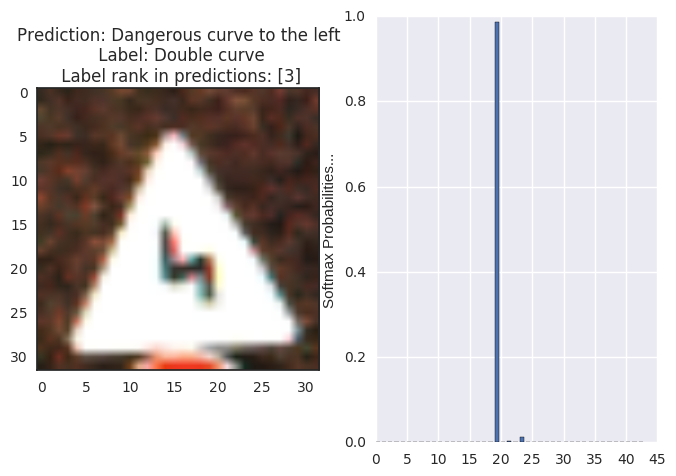

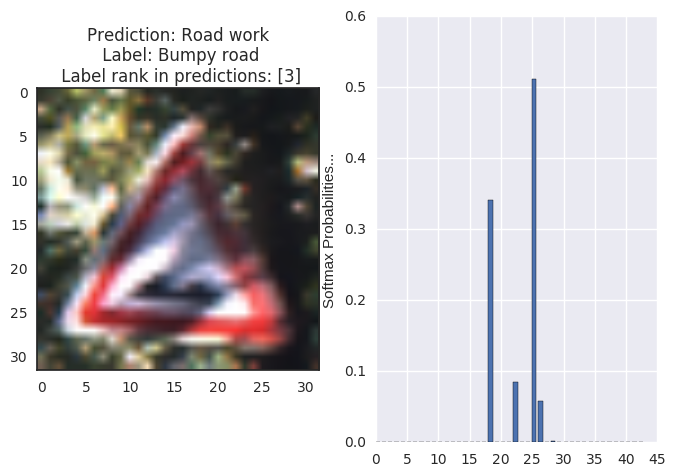

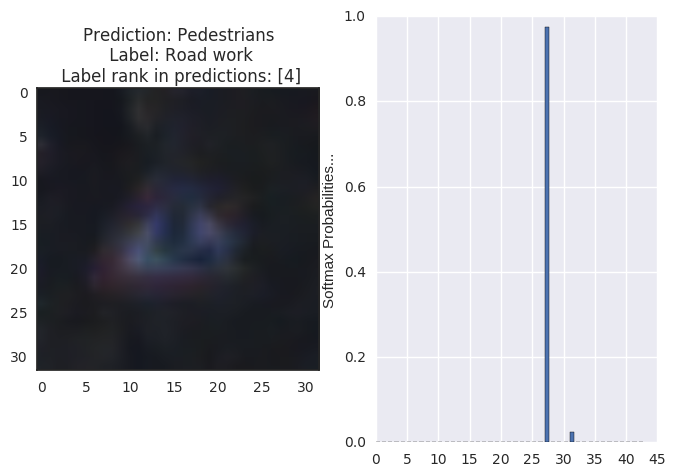

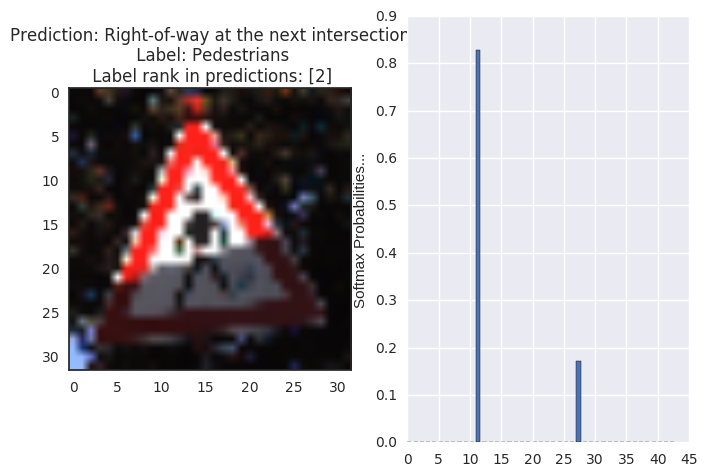

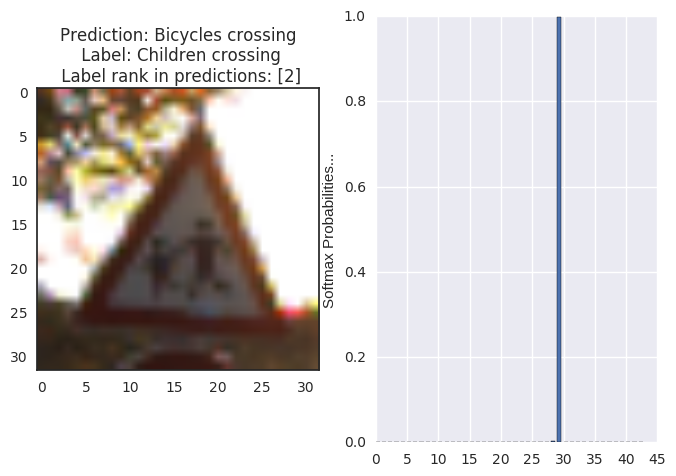

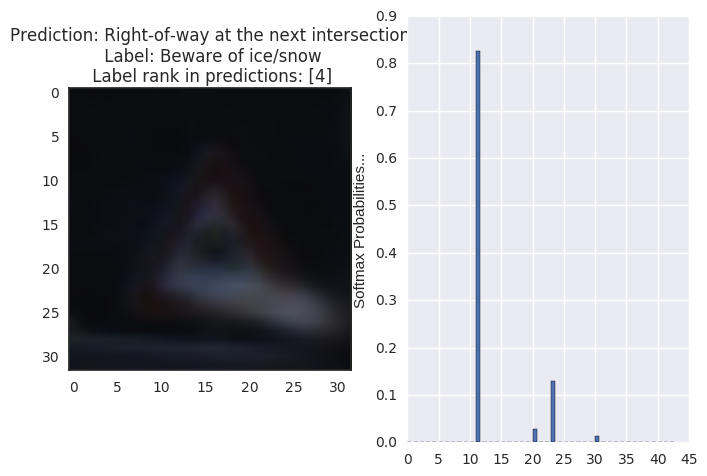

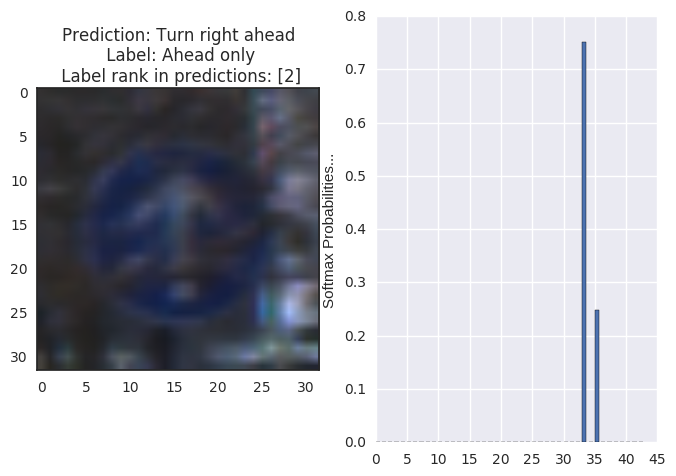

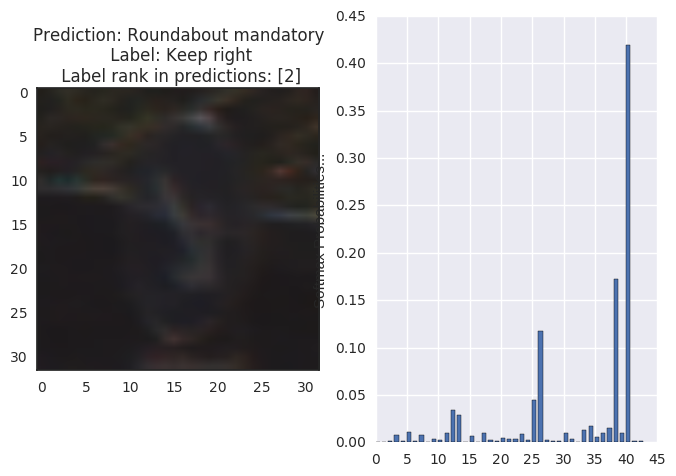

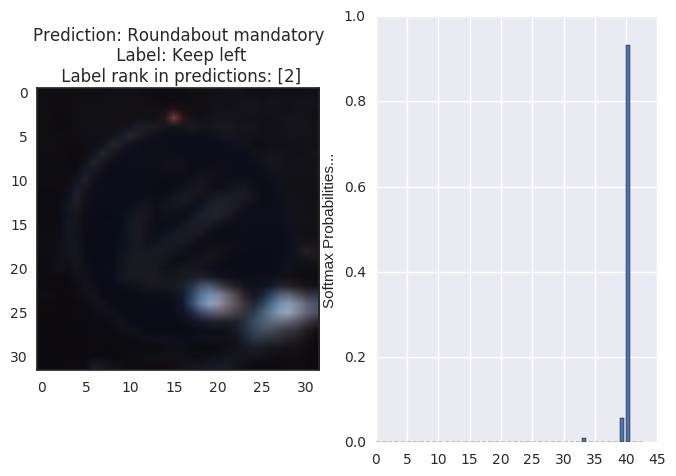

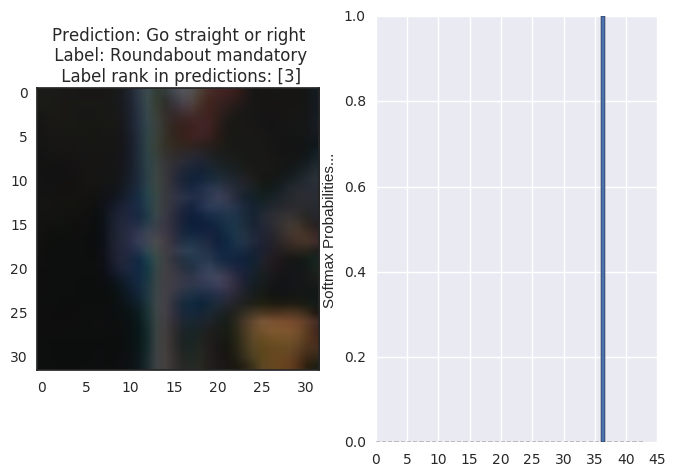

In [74]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# A few misclassified examples in every class...
for i in range(num_classes):
    idxes = np.argwhere(np.logical_and(y_test != test_predictions, y_test==i))
    # If misclassified images...
    if len(idxes):
        idx = int(idxes[0])
        image = X_test[idx]
        
        # Prediction and top-5 predictions...
        prediction = test_predictions[idx]
        top_k = np.argsort(test_probabilities[idx])[:-6:-1]
        label_rank = num_classes - np.argwhere(np.argsort(test_probabilities[idx])==y_test[idx])[0]
        
        # Plot image with probability mask.
        with sns.axes_style("white"):
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title('Prediction: %s\n Label: %s\n Label rank in predictions: %s' % (class_names[prediction], 
                                                                  class_names[y_test[idx]], 
                                                                  label_rank))
        # Bar plot with softmax probabilities.
        plt.subplot(1, 2, 2)
        plt.bar(list(range(num_classes)), test_probabilities[idx], 1 / 1.5)
        plt.ylabel('Softmax Probabilities...')
        plt.show()

### Accuracy discussion

On the test dataset, the model seems to have difficulties concentrated on a few classes:
* End of speed (0.88);
* Double curve (0.67);
* Pedestrians (0.900);
* Beware of ice/snow (0.82);

Note that as shown in the examples above, the correct label is often part of the top-5 classification.

This classification difficulty does not seem to be correlated to the number of samples in the training set, other classes with fewer samples have a much higher rate. A possible explanation may be that the design of these traffic signs is more complex than other classes, making it harder to build robust features and classification for them. For instance, as shown in the example above, it is sometimes rather complicated to make the difference between 'Go straight or right', 'Pedestrians', 'Double curve' and 'Beware of ice/snow' signs.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I chosed several random images on internet. As we can see below, several factors make the classification challenging:
* Orientation of the traffic sign;
* Zoom level;
* Partial occlusion;
* Light reflexion and noise;

In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

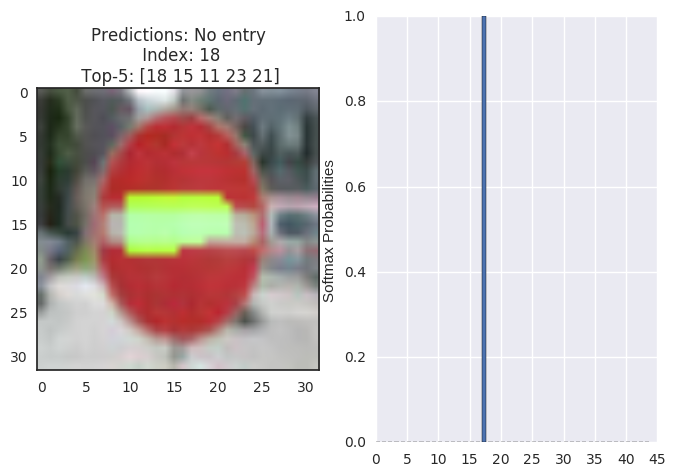

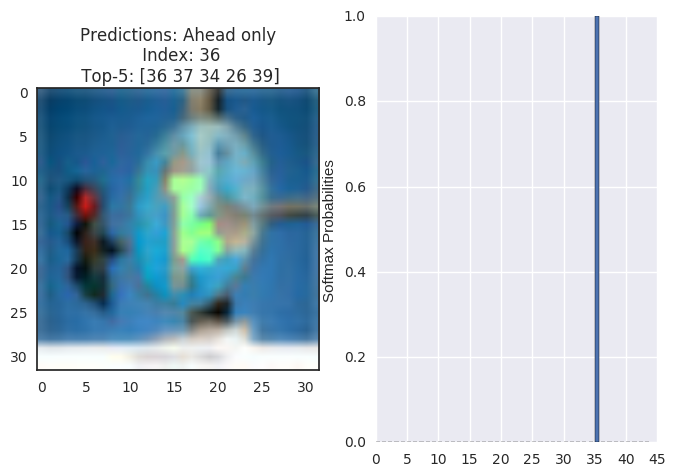

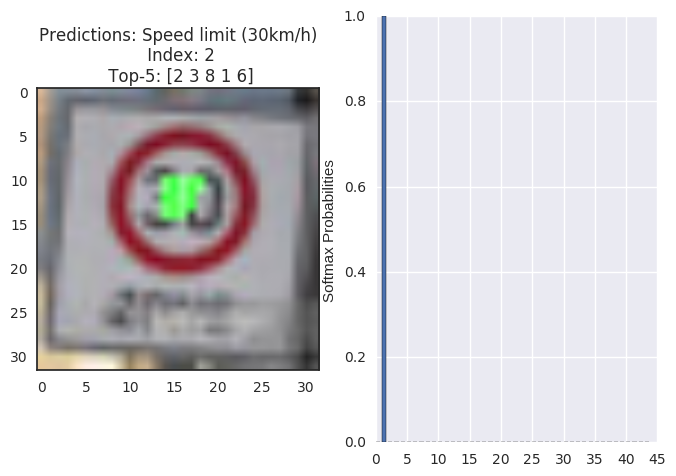

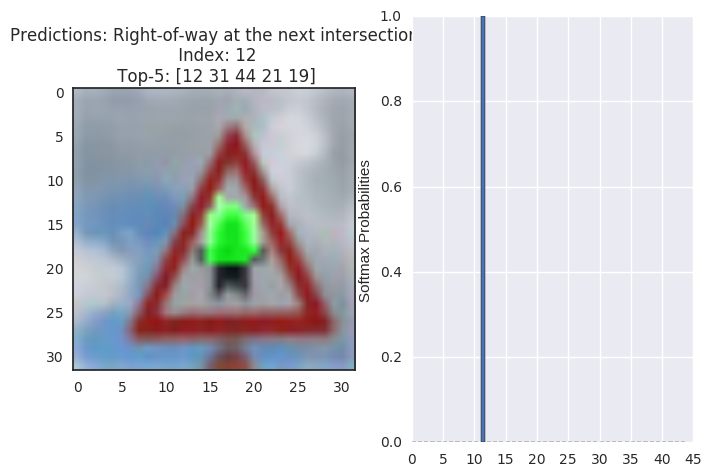

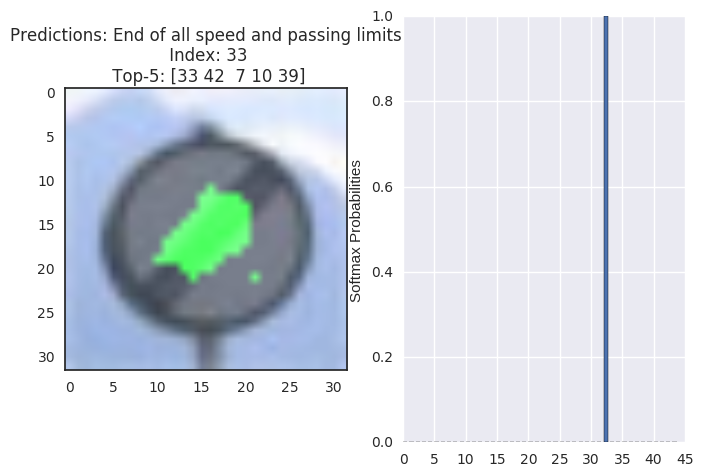

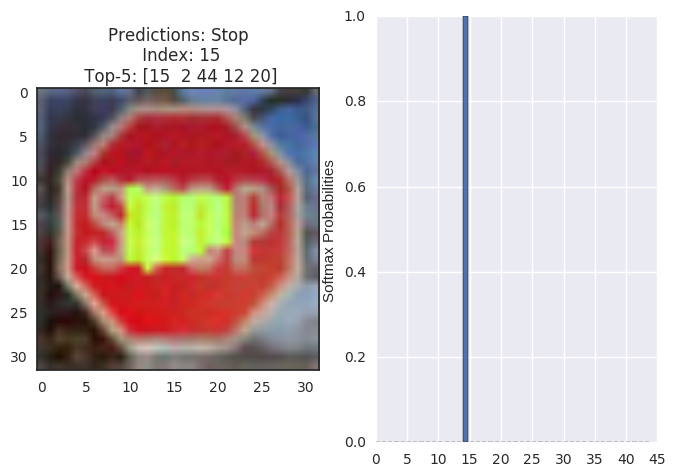

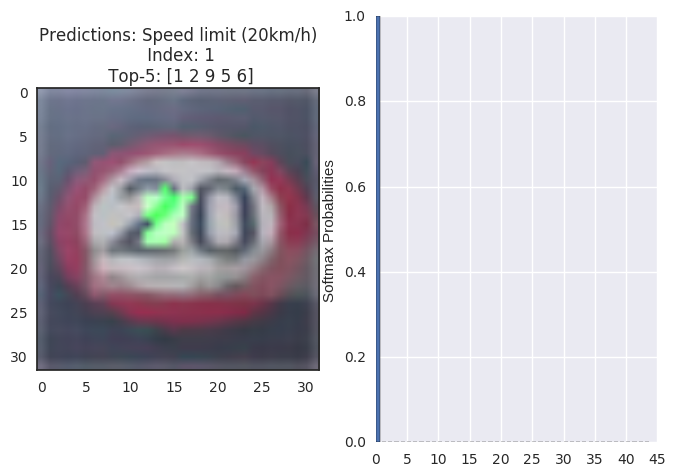

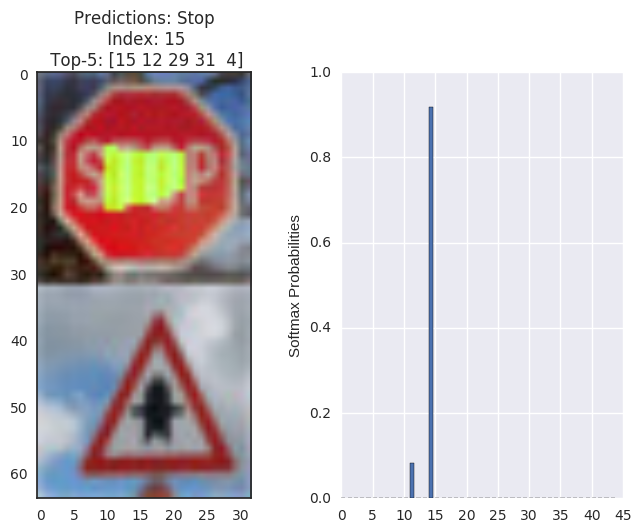

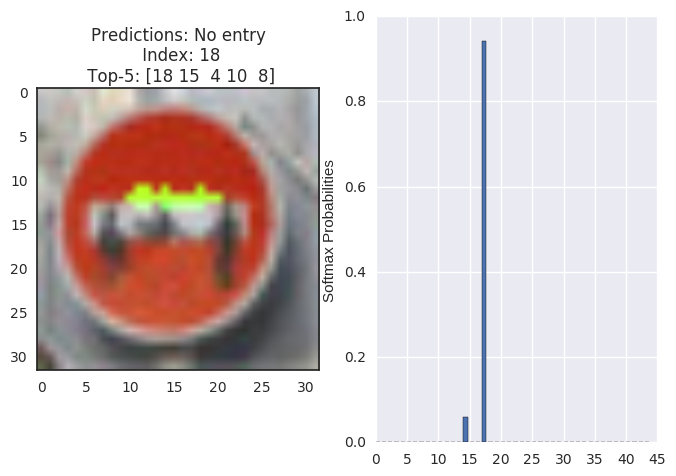

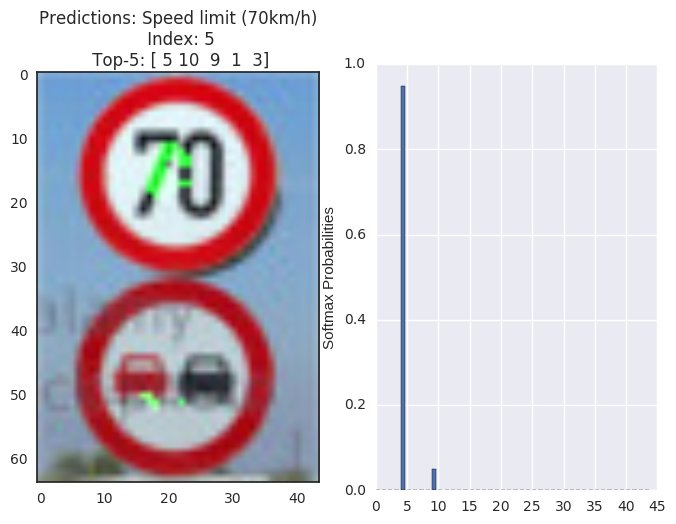

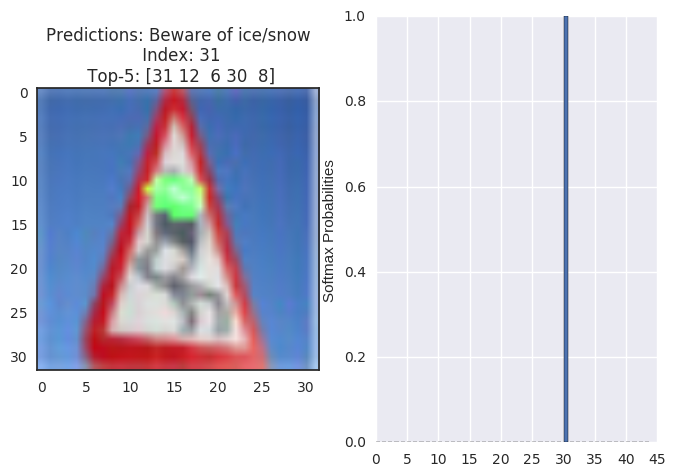

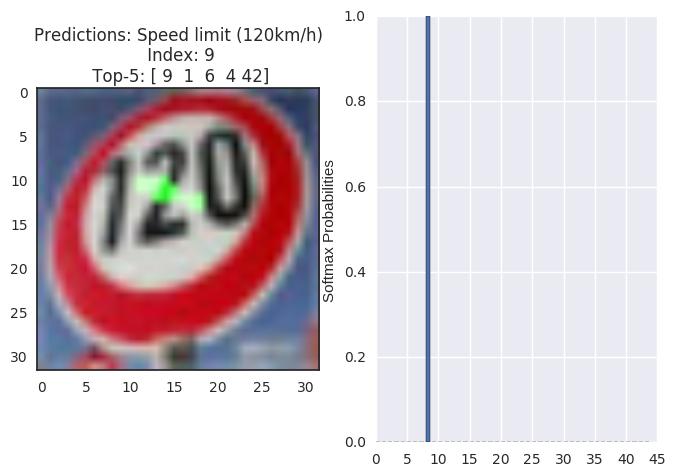

In [77]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)


# Test the predictions on the images directory
list_imgs = os.listdir("images/")
for img_path in list_imgs:
    if img_path[-4:] == '.jpg':
        image = mpimg.imread('images/' + img_path)
        
        # Prediction?
        idx, probabilities, output = eval_model_on_image(image, atrousnet_model, ckpt_file_atrousnet)
        pmap = output['PredictionsFull'][0]
        # Top 5 predictions.
        top_k = np.argsort(probabilities)[:-6:-1]+1
        
        # Mask image
        pad = (image.shape[0]-pmap.shape[0]) // 2
        mask_pad = np.pad(pmap[:,:,idx], pad, 'constant', constant_values=0.0) > 0.99
        mask_img = np.zeros(image.shape, dtype=np.uint8)
        mask_img[:,:,1] = mask_pad * 255
        
        # Plot image with probability mask.
        with sns.axes_style("white"):
            plt.subplot(1, 2, 1)
            plt.imshow(weighted_img(image, mask_img))
            plt.title('Predictions: %s\n Index: %i\n Top-5: %s' % (class_names[idx], idx+1, top_k))
        
        # Bar plot with softmax probabilities.
        plt.subplot(1, 2, 2)
        plt.bar(list(range(len(probabilities))), probabilities, 1 / 1.5)
        plt.ylabel('Softmax Probabilities')
        plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

Despite trying the model on challenging images quite different from the training dataset, the latter seems to be quite robust, only mistaking one image (class 36 'Ahead only' instead of 37 'Go straight or right'),  but still classifying it in the closest category.

Since the AtrousNet model gives as an ouput softmax probabilities on every pixel, I also displayed as a green mask the latter probabilities for the chosen class. It is interesting to see that the high probability zone is getting smaller when partial occlusion or rotation exist (see for instance the second no entry sign), but nevertheless, the classifier is able to recognise correctly the images thanks to a small zone with very high probability values.

## Extensive use of AtrousNet!

The architecture of AtrousNet is clearly interesting on that aspect, as generating a full softmax probability map could then help to directly construct a segmentation and tracking pipeline on videos. For instance, we present below how the same exact neural network can recognise two different traffic signs on the same image. 

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

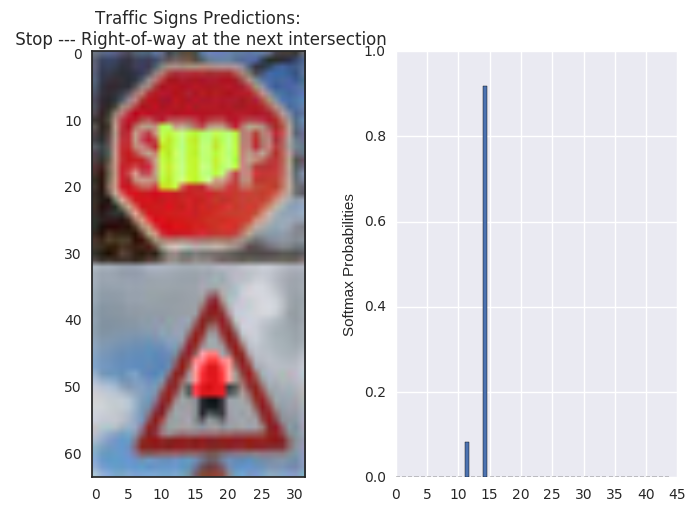

In [87]:
img_path = 'img12.jpg'
image = mpimg.imread('images/' + img_path)

# Prediction?
idx, probabilities, output = eval_model_on_image(image, atrousnet_model, ckpt_file_atrousnet)
pmap = output['PredictionsFull'][0]
# Top 5 predictions.
top_k = np.argsort(probabilities)[:-6:-1]

# Mask image
# mask_pad = np.pad(np.sum(pmap > 0.99999, axis=2), 10, 'constant', constant_values=0.0) > 0.0
pad = (image.shape[0]-pmap.shape[0]) // 2
mask_pad1 = np.pad(pmap[:,:,top_k[0]], pad, 'constant', constant_values=0.0) > 0.99
mask_pad2 = np.pad(pmap[:,:,top_k[1]], pad, 'constant', constant_values=0.0) > 0.99

mask_img = np.zeros(image.shape, dtype=np.uint8)
mask_img[:,:,1] = mask_pad1 * 255
mask_img[:,:,0] = mask_pad2 * 255

# Plot image with probability mask.
with sns.axes_style("white"):
    plt.subplot(1, 2, 1)
    plt.imshow(weighted_img(image, mask_img))
    plt.title('Traffic Signs Predictions:\n %s --- %s' % (class_names[top_k[0]], class_names[top_k[1]]))

# Bar plot with softmax probabilities.
plt.subplot(1, 2, 2)
plt.bar(list(range(len(probabilities))), probabilities, 1 / 1.5)
plt.ylabel('Softmax Probabilities')
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

On all the predictions, even when mistaken, the model is quite certain (p > 0.95). We may nevertheless note that in the one mistake case, the correct solution arrives second in rank, even though quite far in terms of probability.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Extra remarks:

The accuracy of the classifiers could be probably be improved (state of the art is around 99.5%). Compared to the literature, an important factor is that we are working on 32x32 images instead of 48x48. Higher resolution would certainly help to increase performance. In addition, one could also explore the following strategies:
* add occlusion to the preprocessing pipeline;
* deeper model on high resolution images;
* explore different filter sized on Atrous Convolutions.

In addition, it could be fun to apply the pipeline to videos and check if it is able to directly recognise traffic signs from it.